In [1]:
#standard ML/Image Processing imports
import numpy as np
import pandas as pd
import math, pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

#pytorch imports
import torch
import torch.optim as optim
import torchvision.models as models

from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# no one likes irrelevant warnings
import warnings  
warnings.filterwarnings('ignore')

from image_classification_file import ImageFolderWithPathsAndRatings, ImageFolderWithPaths

In [2]:
"""
SCRIPT GLOBAL VARS
"""
# root directory where the images are stored
data_dir = "/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump"#/Fall"#/Dump"
# ratings = None
limit_num_pictures = False #limit_num_pictures = 2000
rated_indices = []
ratings = []
bad_indices = []
# we load the pretrained model, the argument pretrained=True implies to load the ImageNet weights for the pre-trained model
vgg16 = models.vgg16(pretrained=True)

In [3]:
_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

valid_size = 0.2 # percentage of data to use for test set

# load data and apply the transforms on contained pictures
train_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)
test_data = ImageFolderWithPathsAndRatings(data_dir, transform=_transform)   

num_pictures = len(train_data)
print("Number of pictures in subdirectories: {}".format(num_pictures))

# Shuffle pictures and split training set
indices = list(range(num_pictures))
print("Head of indices: {}".format(indices[:10]))

split = int(np.floor(valid_size * num_pictures))
print("Split index: {}".format(split))

# may be unnecessary with the choice of sampler below
np.random.shuffle(indices)
print("Head of shuffled indices: {}".format(indices[:10]))

train_idx, test_idx = indices[split:], indices[:split] #rated_indices, bad_indices
print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))

# Define samplers that sample elements randomly without replacement
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define data loaders, which allow batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_data,
            sampler=train_sampler, batch_size=1)#, num_workers=4)
print("Train loader length: {}".format(len(train_loader)))
test_loader = torch.utils.data.DataLoader(test_data,
            sampler=test_sampler, batch_size=1)#, num_workers=4)
print("Test loader length: {}".format(len(test_loader)))

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device that will be used: {}".format(device))

vgg16.to(device) # loads the model onto the device (CPU or GPU)

Number of pictures in subdirectories: 69704
Head of indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Split index: 13940
Head of shuffled indices: [32177, 1469, 5703, 33735, 45318, 18621, 16656, 21972, 20507, 22910]
Size of training set: 55764, size of test set: 13940
Train loader length: 55764
Test loader length: 13940
Device that will be used: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
for param in vgg16.parameters():
    param.requires_grad = False #freeze all convolution weights
network = list(vgg16.classifier.children())[:-1] #remove fully connected layer
network.extend([nn.Linear(4096, 8)]) #add new layer of 4096->100 (rating scale with 1 decimal - similar to 1 hot encoding)
vgg16.classifier = nn.Sequential(*network)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(vgg16.parameters(), lr=0.4, momentum=0.9) # optimizer

vgg16 #print out the model to ensure our network is correct

vgg16.load_state_dict(torch.load('models/Jan16_All_2017_Fall_Dump_only_labels.pt'))

<All keys matched successfully>

In [5]:
# limit_num_pictures = 13940
# vgg16.eval()

# print(len(test_loader))

# for i, data in enumerate(test_loader):
#     if limit_num_pictures:
#         if i > limit_num_pictures:
#             break
#     # inputs, _, path, label = data
#     inputs, _, _, _ = data
#     # print(label)
#     output = vgg16(inputs)
#     # loss = criterion(output, label)

#     # running_loss += loss.item()
#     _, preds = torch.max(output.data, 1)
#     print(preds)
#     # num_correct += (preds == label).sum().item()
#     print("Classification for test image #{}: {}".format(i, output))


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170928_hallsvillecarnival_nc/20170928_hallsvillecarnival_nc_072.JPG
Classification for test image #0: [1232.94287109375, -478.4044189453125, -393.83074951171875, -455.8734130859375, 970.3912353515625, -370.803955078125, -348.5665283203125, -157.70252990722656]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []


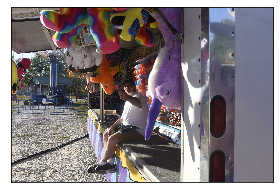


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171002_visitingartist_nc/20171002_visitingartist_nc_026.JPG
Classification for test image #1: [2026.9127197265625, 1539.4178466796875, -1368.703857421875, -1008.6998901367188, -386.242919921875, -338.75653076171875, -318.236572265625, -143.95521545410156]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_318.JPG
Classification for test image #2: [6895.1591796875, -235.4134063720703, -6501.92919921875, -252.49212646484375, 585.2598876953125, -206.76719665527344, -194.09571838378906, -88.0743408203125]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCelebration_EJ/20171209_KwanzaaCelebration_EJ_312.JPG
Classification for test image #3: [29

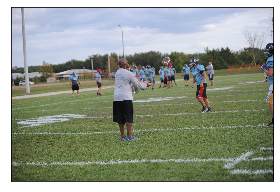


Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170824_SierraApplegate_NC/20170824_SierraApplegate_NC_080.JPG
Classification for test image #21: [5696.74072265625, -910.9105224609375, -3735.2861328125, -842.7137451171875, 485.11102294921875, -292.5932922363281, -274.7866516113281, -124.33904266357422]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170924_showmestates_JJ/20170924_showmestates_JJ_014.JPG
Classification for test image #22: [5758.48095703125, -213.9197235107422, -3215.0322265625, -1258.1124267578125, -297.1649169921875, -326.9172058105469, -307.2869873046875, -138.95452880859375]
Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, file_path]
Index: []

Image path: /mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20171208_affordablechristmas_ec/20171208_affordablechristmas_ec_017.JPG
Classification for test 

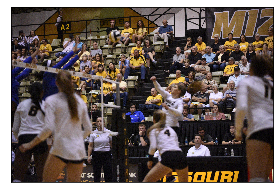

In [6]:
limit_num_pictures = 40
vgg16.eval() # set to prediction mode
testing_loss = 0
testing_accuracy = 0
running_loss = 0.0
num_correct = 0

ratings_data = None
for i, data in enumerate(test_loader, 0):
    
    if limit_num_pictures:
        if i > limit_num_pictures:
            break
    inputs, _, path, label = data
    path = path[0]
    label = torch.LongTensor([int(label[0])])

    output = vgg16(inputs)
    loss = criterion(output, label)

    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    num_correct += (preds == label).sum().item()
    ratings = output[0].tolist()
    print("\nImage path: {}".format(path))
    print("Classification for test image #{}: {}".format(i, ratings))
    tuple_to_insert = {}
    for n in range(8):
        tuple_to_insert[str(n + 1)] = [ratings[n]]
    tuple_to_insert['file_path'] = [path]
    tuple_to_insert = pandas.DataFrame.from_dict(tuple_to_insert)

    if i == 0:
        ratings_data = tuple_to_insert
    else:
        ratings_data = ratings_data.append(tuple_to_insert, ignore_index=True)
    print(ratings_data.tail(0))
    if i % 20 == 0:
        fig = plt.figure(figsize=(16, 4))
        columns = 3
        rows = 1
        img = mpimg.imread(path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

testing_loss = running_loss/len(test_loader.dataset)
testing_accuracy = 100. * num_correct/len(test_loader.dataset)
ratings_data = ratings_data.set_index('file_path')


In [8]:
# ratings_data.set_index('file_path')
ratings_data

,1,2,3,4,5,6,7,8
file_path,,,,,,,,
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20170928_hallsvillecarnival_nc/20170928_hallsvillecarnival_nc_072.JPG",1232.942871,-478.404419,-393.830750,-455.873413,970.391235,-370.803955,-348.566528,-157.702530
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Compton, Nate/20171002_visitingartist_nc/20171002_visitingartist_nc_026.JPG",2026.912720,1539.417847,-1368.703857,-1008.699890,-386.242920,-338.756531,-318.236572,-143.955215
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20170929_MUbbpress_JJ/20170928_mubbpress_JJ_318.JPG",6895.159180,-235.413406,-6501.929199,-252.492126,585.259888,-206.767197,-194.095718,-88.074341
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171209_KwanzaaCelebration_EJ/20171209_KwanzaaCelebration_EJ_312.JPG",2911.635498,-973.233643,45.251297,156.870087,-1817.743286,-136.472748,-128.564011,-58.078598
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Liu, Olivia/20170825_BattleFootball_OL/08252017_BattleFootball_OL_1342.JPG",15355.505859,-1926.779419,-10541.491211,-1131.061035,-1176.406250,-245.972656,-231.079910,-104.304718
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Jeremy/20171208_coleysholidaydrinks_JJ/20171208_coleysholidaydrinks_JJ_007.JPG",8254.768555,-1439.841431,-5880.741699,-339.723389,-151.209106,-186.799774,-175.685165,-79.578331
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Johnson, Emily/20171101_VoxRadioArchives_EJ/20171101_VoxRadioArchive_EJ_078.JPG",9816.490234,-2255.421631,-3228.432617,-872.612915,-2985.247559,-200.266815,-187.741531,-84.232780
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170916_stlprotest2_Ec/2017091_stlprotest_ec_2127.JPG",8073.748047,-2670.913818,-2183.031738,-1553.301392,-945.290771,-305.070190,-286.952118,-129.742950
"/mnt/md0/mysql-dump-economists/Archives/2017/Fall/Dump/Cherryhomes, Ellie/20170909_BoonevilleFootball_ec/1070909_BoonevilleFootball_Ec_086.JPG",15264.706055,-1604.598999,-10802.271484,-2067.126709,-92.936356,-295.439728,-277.149597,-126.113968


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a0737a6d0>,
      dtype=object)

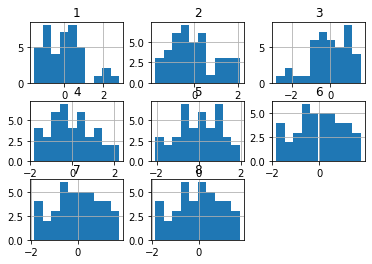

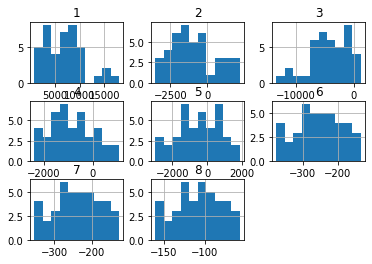

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
space_1 = scaler.fit_transform(ratings_data)
ratings_data_norm = pd.DataFrame(space_1, columns=ratings_data.columns, index=ratings_data.index)
ratings_data_norm.hist()
ratings_data.hist()

In [10]:
ratings_data_norm['classification'] = ratings_data_norm.idxmax(axis=1)
ratings_data_norm = ratings_data_norm.sort_values(by=['classification'])
ratings_data_norm
bad_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '8']
good_images = ratings_data_norm.loc[ratings_data_norm['classification'] == '1']

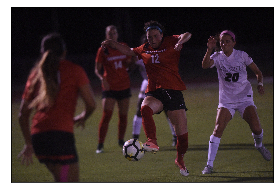

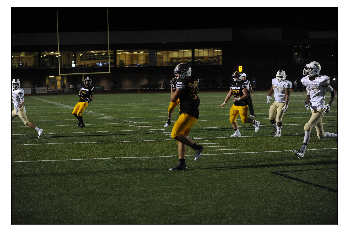

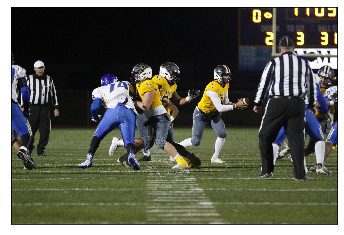

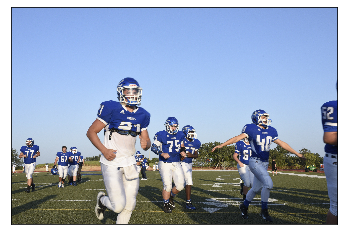

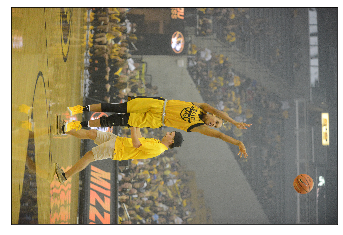

In [11]:
fig = plt.figure(figsize=(16, 4))
for path in good_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

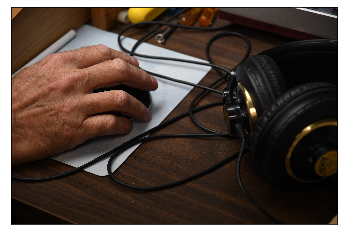

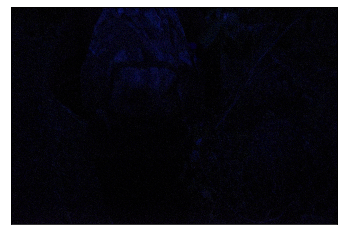

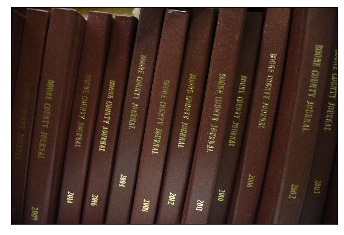

In [12]:
# fig = plt.figure(figsize=(16, 4))
for path in bad_images.head().index:
    columns = 3
    rows = 1
    img = mpimg.imread(path)
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()